In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

# We will import a customized function called client which actually returns an authorized bigquery client object with right credentials
# this will cost us an extra pair of () each time we call the client object which is now called by the function client we define in bq_sa_auth.py 

from bq_sa_auth import client

### [As & With](https://www.kaggle.com/code/dansbecker/as-with/tutorial)
#### Organize your query for better readability. This becomes especially important for complex queries.

-----------------------------------------------------------------------------------------------------

#### Example: How many Bitcoin transactions are made per month?

#### We're going to use a comman table expression (CTE) to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

#### We'll investigate the transactions table. Here is a view of the first few rows.

In [2]:
# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client().dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client().get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client().get_table(table_ref)

# Preview the first five lines of the "transactions" table
client().list_rows(table, max_results=5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


### Since the `block_timestamp` column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the DATE() command.

### We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [3]:
# Query to select the number of transactions per date, sorted by date

query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS num_transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)

query_job = client().query(query_with_CTE, job_config=safe_config)

bitcoin_trans_perdate = query_job.to_dataframe()

bitcoin_trans_perdate.head(20)

,num_transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12
5,123,2009-01-13
6,130,2009-01-14
7,134,2009-01-15
8,110,2009-01-16
9,109,2009-01-17


Text(0.5, 0, 'transaction date')

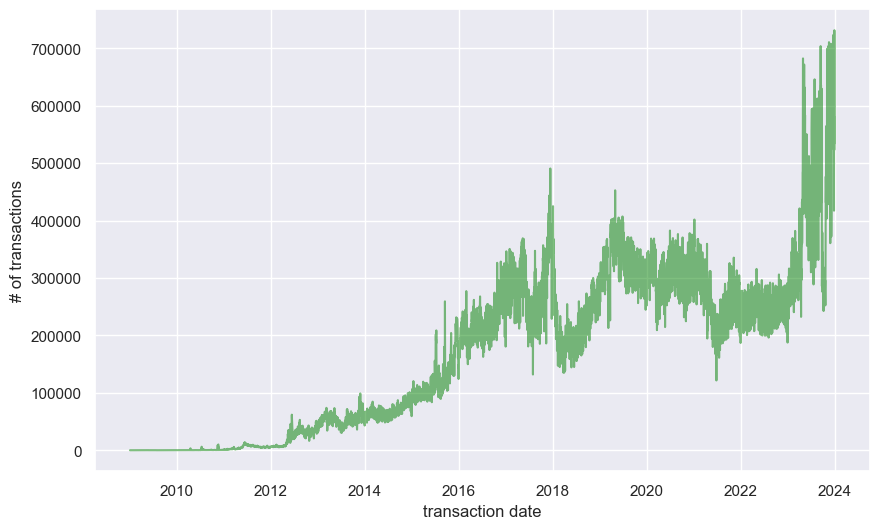

In [4]:
# Plot the results 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(bitcoin_trans_perdate.set_index('trans_date'), color = 'green', alpha = 0.5)

ax.set_ylabel('# of transactions')
ax.set_xlabel('transaction date')

### As you can see, common table expressions (CTEs) let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.

### **Exercises:**

#### We will work with a dataset about taxi trips in the city of Chicago. Run the cell below to fetch the `chicago_taxi_trips` dataset.

In [5]:
# Construct a reference to the "chicago_taxi_trips" dataset
taxichic_ref = client().dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
taxichic_ds = client().get_dataset(taxichic_ref)

#### You are curious how much slower traffic moves when traffic volume is high. This involves a few steps.

### 1) Find the data

#### Before you can access the data, you need to find the table name with the data.

In [6]:
tables = list(client().list_tables(taxichic_ds))

for tab in tables:
    print(tab.table_id)

taxi_trips


### 2) Peek at the data

#### peek at the top few rows of the data. Inspect the data and see if any issues with data quality are immediately obvious. 

In [7]:
# Construct a reference to the "full" table
table_ref = taxichic_ref.table("taxi_trips")

# API request - fetch the table
taxi_trips_table = client().get_table(table_ref)


taxi_trips_table.schema

[SchemaField('unique_key', 'STRING', 'REQUIRED', None, 'Unique identifier for the trip.', (), None),
 SchemaField('taxi_id', 'STRING', 'REQUIRED', None, 'A unique identifier for the taxi.', (), None),
 SchemaField('trip_start_timestamp', 'TIMESTAMP', 'NULLABLE', None, 'When the trip started, rounded to the nearest 15 minutes.', (), None),
 SchemaField('trip_end_timestamp', 'TIMESTAMP', 'NULLABLE', None, 'When the trip ended, rounded to the nearest 15 minutes.', (), None),
 SchemaField('trip_seconds', 'INTEGER', 'NULLABLE', None, 'Time of the trip in seconds.', (), None),
 SchemaField('trip_miles', 'FLOAT', 'NULLABLE', None, 'Distance of the trip in miles.', (), None),
 SchemaField('pickup_census_tract', 'INTEGER', 'NULLABLE', None, 'The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.', (), None),
 SchemaField('dropoff_census_tract', 'INTEGER', 'NULLABLE', None, 'The Census Tract where the trip ended. For privacy, this Census Tract is not s

In [8]:
client().list_rows(taxi_trips_table,max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,d2f7afe2dbe9a7a883bcd2bea8a61b4f1ca9ee50,312a81d2e122cf94378492abd78371da19017e26f1bb7d...,2019-06-25 14:45:00+00:00,2019-06-25 15:00:00+00:00,552,1.40,<NA>,<NA>,<NA>,<NA>,...,0.0,7.75,Cash,City Service,NaN,NaN,None,NaN,NaN,None
1,d2f3833d31b230290e1dbab284da40eb164557ac,4ceed9f280171cebce539cee58acec704cf2f1dca2f89e...,2019-06-03 19:00:00+00:00,2019-06-03 19:00:00+00:00,319,0.96,<NA>,<NA>,<NA>,<NA>,...,0.0,9.50,Credit Card,Chicago Carriage Cab Corp,NaN,NaN,None,NaN,NaN,None
2,d2f82eef85794ca47a8389264c4ec40337d538f8,b71b6ac8ce80a63f080b0b1797320425c67b74af57bdd7...,2019-06-01 21:45:00+00:00,2019-06-01 22:00:00+00:00,608,2.26,<NA>,<NA>,<NA>,<NA>,...,0.0,9.25,Cash,Chicago Carriage Cab Corp,NaN,NaN,None,NaN,NaN,None
3,d2feffe082a67bd9483fc2a6e6c56a7e341fe1eb,63f04d77360d12a3b71ebabb82794a2cc1842a1f5a147c...,2019-06-12 17:30:00+00:00,2019-06-12 17:45:00+00:00,1441,4.23,<NA>,<NA>,<NA>,<NA>,...,0.0,16.50,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None
4,d3005e16e1cbb94006a6c7219e35ee7aa165678f,4b9b91a8648e40ebafcc374aaf02db473cb8e1953f0c4f...,2019-06-05 16:00:00+00:00,2019-06-05 16:15:00+00:00,531,2.34,<NA>,<NA>,<NA>,<NA>,...,5.0,14.25,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None


In [ ]:
# There is some NaN and NA values in some columns 

### 3) Determine when this data is from

If the data is sufficiently old, we might be careful before assuming the data is still relevant to traffic patterns today. Write a query that counts the number of trips in each year.  

Your results should have two columns:
- `year` - the year of the trips
- `num_trips` - the number of trips in that year

Hints:
- When using **GROUP BY** and **ORDER BY**, you should refer to the columns by the alias `year` that you set at the top of the **SELECT** query.
- The SQL code to **SELECT** the year from `trip_start_timestamp` is <code>SELECT EXTRACT(YEAR FROM trip_start_timestamp)</code>
- The **FROM** field can be a little tricky until you are used to it.  The format is:
    1. A backick (the symbol \`).
    2. The project name. In this case it is `bigquery-public-data`.
    3. A period.
    4. The dataset name. In this case, it is `chicago_taxi_trips`.
    5. A period.
    6. The table name. You used this as your answer in **1) Find the data**.
    7. A backtick (the symbol \`).

In [9]:
tt_yearly_query = """ 
                 SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, COUNT(1) as num_trips
                 FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                 GROUP BY year
                 ORDER BY year DESC
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)

query_job = client().query(tt_yearly_query, job_config=safe_config)

taxi_trips_yearly = query_job.to_dataframe()

taxi_trips_yearly.head(20)

,year,num_trips
0,2023,6030387
1,2022,6382071
2,2021,3947677
3,2020,3888831
4,2019,16476440
5,2018,20731105
6,2017,24979611
7,2016,31756403
8,2015,32385527
9,2014,37395079


### 4) Dive slightly deeper

You'd like to take a closer look at rides from 2016.  Copy the query you used above in `rides_per_year_query` into the cell below for `rides_per_month_query`.  Then modify it in two ways:
1. Use a **WHERE** clause to limit the query to data from 2016.
2. Modify the query to extract the month rather than the year.

In [10]:
tt_monthly_query = """
                 SELECT EXTRACT(MONTH FROM trip_start_timestamp) AS month, COUNT(1) as num_trips
                 FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                 WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2016
                 GROUP BY month
                 ORDER BY num_trips DESC
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)

query_job = client().query(tt_monthly_query, job_config=safe_config)

taxi_trips_monthly = query_job.to_dataframe()

taxi_trips_monthly.head(20)

,month,num_trips
0,5,2859147
1,4,2854290
2,3,2851106
3,6,2841872
4,10,2725340
5,7,2682912
6,8,2629482
7,2,2568433
8,9,2532650
9,1,2510389


### 5) Write the query

It's time to step up the sophistication of your queries.  Write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

Your results should have three columns:
- `hour_of_day` - sort by this column, which holds the result of extracting the hour from `trip_start_timestamp`.
- `num_trips` - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
- `avg_mph` - the average speed, measured in miles per hour, for trips that started in that hour of the day.  Average speed in miles per hour is calculated as `3600 * SUM(trip_miles) / SUM(trip_seconds)`. (The value 3600 is used to convert from seconds to hours.)

Restrict your query to data meeting the following criteria:
- a `trip_start_timestamp` > **2016-01-01** and < **2016-04-01**
- `trip_seconds` > 0 and `trip_miles` > 0

You will use a common table expression (CTE) to select just the relevant rides.  Because this dataset is very big, this CTE should select only the columns you'll need to create the final output (though you won't actually create those in the CTE -- instead you'll create those in the later **SELECT** statement below the CTE).

This is a much harder query than anything you've written so far.  Good luck!

In [11]:
# First filter relevant rides according to the criterions above using WITH ... AS
# Then do the relevant calculations and sorting 

tt_hourly_query = """
                 WITH relevant_rides AS 
                 (
                     SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, trip_seconds, trip_miles
                     FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                     WHERE trip_start_timestamp > '2016-01-01' AND
                           trip_start_timestamp < '2016-04-01' AND
                           trip_seconds > 0 AND trip_miles > 0
                 ) 
                 SELECT hour_of_day, COUNT(1) as num_trips, 3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
                 FROM relevant_rides
                 GROUP BY hour_of_day
                 ORDER BY hour_of_day
                 """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)

query_job = client().query(tt_hourly_query, job_config=safe_config)

taxi_trips_hourly = query_job.to_dataframe()

taxi_trips_hourly.head(24)

,hour_of_day,num_trips,avg_mph
0,0,203092,20.191744
1,1,178046,18.628598
2,2,143447,18.444370
3,3,108899,19.273107
4,4,80067,27.599669
5,5,75786,33.065604
6,6,102254,28.533112
7,7,187585,19.884592
8,8,284223,16.787900
9,9,306854,18.434124
